<a href="https://colab.research.google.com/github/PhillipOverloeper/BarlowTwins/blob/main/BarlowTwins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Standardtext für Titel
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.5 MB/s 
     |████████████████████████████████| 140 kB 57.9 MB/s 
     |████████████████████████████████| 419 kB 57.3 MB/s 
     |████████████████████████████████| 596 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 56.2 MB/s 
     |████████████████████████████████| 144 kB 72.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 33.4 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=ba4f6af832b0c4196a8275f01e3360ccd1836f6972f50b960a1d6b0496429c89
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [3]:
from functools import partial
from typing import Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import gpytorch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
from pytorch_lightning import Callback, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid

batch_size = 32
num_workers = 0  # to run notebook on CPU
max_epochs = 50
z_dim = 128

In [4]:
class BarlowTwinsTransform:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):

        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.finetune_transform(sample)

In [5]:
def cifar10_normalization():
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  return normalize

train_transform = BarlowTwinsTransform(train=True, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization())
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)

val_transform = BarlowTwinsTransform(train=False, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization())
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


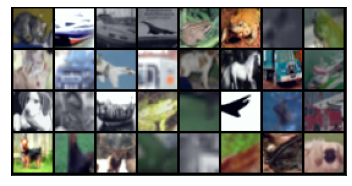

In [6]:
for batch in val_loader:
  (img1, img2, _), label = batch
  break


img_grid = make_grid(img1, normalize=True)

def show(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
    img = img.detach()
    img = VisionF.to_pil_image(img)
    axs[0,i].imshow(np.asarray(img))
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(img_grid)



In [7]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=5e-3, z_dim=128):
        super().__init__()

        self.z_dim = z_dim
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        # taken from: https://github.com/facebookresearch/barlowtwins/blob/main/main.py
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def kernel_loss(self,x):

        cross_corr = x

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()

        return on_diag + self.lambda_coeff * off_diag

    def forward(self, z1, z2):
        # N x D, where N is the batch size and D is output dim of projection head
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)

        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()

        return on_diag + self.lambda_coeff * off_diag

In [8]:
encoder = resnet18()

# for CIFAR10, replace the first 7x7 conv with smaller 3x3 conv and remove the first maxpool
encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
encoder.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# replace classification fc layer of Resnet to obtain representations from the backbone
encoder.fc = nn.Identity()

In [9]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        x = self.projection_head(x)
        return x

In [15]:
class Kernel(nn.Module):
  def __init__(self, batch_size=32):
    super().__init__()

    self.batch_size = batch_size
    self.sigma = 1/5.6
    self.empty = torch.empty(batch_size,batch_size)


  def RBF(self, x, y):

    #c = ((torch.matmul(x, torch.t(x)) + torch.matmul(y, torch.t(y)) - 2 * torch.matmul(x,torch.t(y)))*-0.2).exp_()

    c = (torch.cdist(x, y, p=2) * -self.sigma).exp_()
    c = c + 0
    
   

    

  
    """
    for i in range(x.shape[0]):
      for j in range(y.shape[0]):
        c[i,j] = torch.exp(-1*torch.pow(torch.sum(torch.abs(torch.sub(x[i],y[j]))),2)/self.sigma)

    print(c)
    """
    return c

  


In [11]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0


def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

In [17]:
class BarlowTwins(LightningModule):
    def __init__(
        self,
        encoder,
        encoder_out_dim,
        num_training_samples,
        batch_size,
        lambda_coeff=5e-3,
        z_dim=128,
        learning_rate=1e-4,
        warmup_epochs=10,
        max_epochs=200,
    ):
        super().__init__()

        self.encoder = encoder
        self.projection_head = ProjectionHead(input_dim=encoder_out_dim, hidden_dim=encoder_out_dim, output_dim=z_dim)
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size, lambda_coeff=lambda_coeff, z_dim=z_dim)

        self.kernel = Kernel(batch_size=batch_size)

        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs

        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch

        h1 = self.encoder(x1)
        h2 = self.encoder(x2)

        #print(x1.shape)
        #print(h1.shape)

        h1_norm = (h1 - torch.mean(h1, dim=0)) / torch.std(h1, dim=0)
        h2_norm = (h2 - torch.mean(h2, dim=0)) / torch.std(h2, dim=0)

        h3 = self.kernel.RBF(h1_norm,h2_norm)

        #z1 = self.projection_head(self.encoder(x1))
        #z2 = self.projection_head(self.encoder(x2))

 

        #loss1 = self.loss_fn(z1, z2)
        loss2 = self.loss_fn.kernel_loss(h3)

        

        return loss2

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)

        self.log("train_loss", loss.item(), on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [13]:
"""
class OnlineFineTuner(Callback):
    def __init__(
        self,
        encoder_output_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()

        self.optimizer: torch.optim.Optimizer

        self.encoder_output_dim = encoder_output_dim
        self.num_classes = num_classes

    def on_pretrain_routine_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:

        # add linear_eval layer and optimizer
        pl_module.online_finetuner = nn.Linear(self.encoder_output_dim, self.num_classes).to(pl_module.device)
        self.optimizer = torch.optim.Adam(pl_module.online_finetuner.parameters(), lr=1e-4)

    def extract_online_finetuning_view(
        self, batch: Sequence, device: Union[str, torch.device]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        (_, _, finetune_view), y = batch
        finetune_view = finetune_view.to(device)
        y = y.to(device)

        return finetune_view, y

    def on_train_batch_end(
        self,
        trainer: pl.Trainer,
        pl_module: pl.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
        dataloader_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        acc = accuracy(F.softmax(preds, dim=1), y)
        pl_module.log("online_train_acc", acc, on_step=True, on_epoch=False)
        pl_module.log("online_train_loss", loss, on_step=True, on_epoch=False)

    def on_validation_batch_end(
        self,
        trainer: pl.Trainer,
        pl_module: pl.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
        dataloader_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        acc = accuracy(F.softmax(preds, dim=1), y)
        pl_module.log("online_val_acc", acc, on_step=False, on_epoch=True, sync_dist=True)
        pl_module.log("online_val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)
"""

'\nclass OnlineFineTuner(Callback):\n    def __init__(\n        self,\n        encoder_output_dim: int,\n        num_classes: int,\n    ) -> None:\n        super().__init__()\n\n        self.optimizer: torch.optim.Optimizer\n\n        self.encoder_output_dim = encoder_output_dim\n        self.num_classes = num_classes\n\n    def on_pretrain_routine_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:\n\n        # add linear_eval layer and optimizer\n        pl_module.online_finetuner = nn.Linear(self.encoder_output_dim, self.num_classes).to(pl_module.device)\n        self.optimizer = torch.optim.Adam(pl_module.online_finetuner.parameters(), lr=1e-4)\n\n    def extract_online_finetuning_view(\n        self, batch: Sequence, device: Union[str, torch.device]\n    ) -> Tuple[torch.Tensor, torch.Tensor]:\n        (_, _, finetune_view), y = batch\n        finetune_view = finetune_view.to(device)\n        y = y.to(device)\n\n        return finetune_view, y\n\n    def on_tr

In [ ]:
encoder_out_dim = 512

model = BarlowTwins(
    encoder=encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(train_dataset),
    batch_size=batch_size,
    z_dim=z_dim,
)

#online_finetuner = OnlineFineTuner(encoder_output_dim=encoder_out_dim, num_classes=10)
#checkpoint_callback = ModelCheckpoint(every_n_epochs=100, save_top_k=-1, save_last=True)

trainer = Trainer(
    max_epochs=max_epochs,
    gpus=torch.cuda.device_count(),
    precision=16 if torch.cuda.device_count() > 0 else 32,
    #callbacks=[online_finetuner, checkpoint_callback],
)

# uncomment this to train the model
# this is done for the tutorial so that the notebook compiles
trainer.fit(model, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | encoder         | ResNet          | 11.2 M
1 | projection_head | ProjectionHead  | 329 K 
2 | loss_fn         | BarlowTwinsLoss | 0     
3 | kernel          | Kernel          | 0     
----------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
22.996    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]